# Homework 9: Variational Autoencoders


In [1]:
%matplotlib inline

import os
import math
import torch
import matplotlib.pyplot as plt
import torch.utils.data
from matplotlib import pyplot
from torchvision import utils
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision.utils import save_image

In [2]:
def show_image(image): 
    pyplot.imshow(image, cmap="gray")

def show_mnist_batch(sample_batched):
    """Show images for a batch of samples."""
    images_batch = sample_batched[0]
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from DataLoader')

## Load data

In [3]:
!mkdir data

mkdir: data: File exists


In [4]:
transformations = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = datasets.MNIST('./data', download=True, train=True, transform=transformations)
mnist_test = datasets.MNIST('./data', download=True, train=False, transform=transformations)

print(f"{len(mnist_train)} training images")
print(f"{len(mnist_test)} test images")

60000 training images
10000 test images


In [5]:
batch_size =  32
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(mnist_test, batch_size=batch_size, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


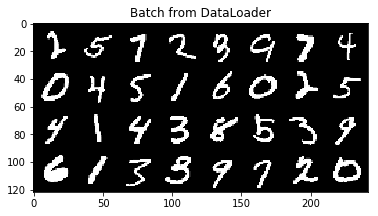

In [6]:
# Displays the first batch of images
for i, batch in enumerate(train_loader):
    if i==1:
        break
    show_mnist_batch(batch)

## VAE Model

In [7]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # ENCODER
        self.fc1 = nn.Linear(784, 400)

        # max(0, x)
        self.relu = nn.ReLU()
        self.fc21 = nn.Linear(400, 20)  # mu layer
        self.fc22 = nn.Linear(400, 20)  # logvariance layer
        # this last layer bottlenecks through 20 connections

        # DECODER
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x: Variable) -> (Variable, Variable):
        # h1 is [128, 400]
        h1 = self.relu(self.fc1(x))  # type: Variable
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu: Variable, logvar: Variable) -> Variable:
        if self.training:
            std = logvar.mul(0.5).exp_()  # type: Variable
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)

        else:
            return mu

    def decode(self, z: Variable) -> Variable:
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x: Variable) -> (Variable, Variable, Variable):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [8]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
import time
time.time()

learning_rate = .002
model = VAE()
optimizer = Adam(model.parameters(), lr=learning_rate)

In [9]:
def loss_function(recon_x, x, mu, logvar) -> Variable:
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD /= batch_size * 784

    # BCE tries to make our reconstruction as accurate as possible
    # KLD tries to push the distributions as close as possible to unit Gaussian
    return BCE + KLD

In [10]:
LOG_INTERVAL = 100
NUM_EPOCHS = 10

def train(epoch):
    model.train()
    train_loss = 0
          
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
          
        recon_batch, mu, logvar = model(data)
          
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [11]:
def test(epoch): 
    model.eval()
    test_loss = 0
    
    for batch_idx, (data, _) in enumerate(test_loader):
        data = Variable(data)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).item()
        if batch_idx == 0:
            n = min(data.size(0), 8)
            # for the first 128 batch of the epoch, show the first 8 input digits
            # with right below them the reconstructed output digits
            comparison = torch.cat([data[:n],recon_batch.view(batch_size, 1, 28, 28)[:n]])
            save_image(comparison.data.cpu(),'results/reconstruction_' + str(epoch) + '.png', nrow=n)
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

## Train model and generate images 

In [ ]:
for epoch in range(1, NUM_EPOCHS):
    train(epoch)
    test(epoch)
    sample = Variable(torch.randn(32, 20))
    sample = model.decode(sample).cpu()
    save_image(sample.data.view(32, 1, 28, 28),
               'results/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.021879
Train Epoch: 1 [3200/60000 (5%)]	Loss: -0.503785
Train Epoch: 1 [6400/60000 (11%)]	Loss: -0.607380
Train Epoch: 1 [9600/60000 (16%)]	Loss: -0.665955
Train Epoch: 1 [12800/60000 (21%)]	Loss: -0.743563
Train Epoch: 1 [16000/60000 (27%)]	Loss: -0.733883
Train Epoch: 1 [19200/60000 (32%)]	Loss: -0.769062
Train Epoch: 1 [22400/60000 (37%)]	Loss: -0.752311
Train Epoch: 1 [25600/60000 (43%)]	Loss: -0.809703
Train Epoch: 1 [28800/60000 (48%)]	Loss: -0.851301
Train Epoch: 1 [32000/60000 (53%)]	Loss: -0.837514
Train Epoch: 1 [35200/60000 (59%)]	Loss: -0.880812
Train Epoch: 1 [38400/60000 (64%)]	Loss: -0.850764
Train Epoch: 1 [41600/60000 (69%)]	Loss: -0.871060
Train Epoch: 1 [44800/60000 (75%)]	Loss: -0.890810
Train Epoch: 1 [48000/60000 (80%)]	Loss: -0.839874
Train Epoch: 1 [51200/60000 (85%)]	Loss: -0.861927
Train Epoch: 1 [54400/60000 (91%)]	Loss: -0.896874
Train Epoch: 1 [57600/60000 (96%)]	Loss: -0.917540
====> Epoch: 1 Average loss: -0.7758
====